# Setup & Config for test1_data_annotated.vcf file analysis

In [1]:
import os, gzip, json, traceback, subprocess, re
from collections import defaultdict, Counter
from datetime import datetime

# Path of my annotated VCF file
vcf_path = r"D:\clovertex_assignment\test1_data_annotated.vcf"


# Output directory and log paths
out_dir = os.path.splitext(vcf_path)[0] + "_analysis"
os.makedirs(out_dir, exist_ok=True)
json_log_path = os.path.join(out_dir, "vcf_analysis_log.json")
text_log_path = os.path.join(out_dir, "vcf_analysis_log.txt")

# Important functions

In [4]:
def open_vcf(path: str):
    return gzip.open(path, 'rt') if path.endswith('.gz') else open(path, 'r')

def parse_csq_header(vcf_file):
    """Extract CSQ header fields from INFO line."""
    csq_format = None
    header_lines = []
    for line in vcf_file:
        if not line.startswith("#"):
            break
        header_lines.append(line.rstrip("\n"))
        if line.startswith("##INFO=<ID=CSQ"):
            m = re.search(r'Format:\s*([^">]+)', line)
            if m:
                csq_format = [x.strip() for x in m.group(1).split('|')]
    return csq_format, header_lines

def parse_info_field(info_str):
    d = {}
    for part in info_str.split(";"):
        if "=" in part:
            k,v = part.split("=",1)
            d[k]=v
        else:
            d[part] = ""
    return d

def safe_get_csq_annotations(info_dict, csq_fields):
    """Return list of dicts (annotations) for CSQ field."""
    if 'CSQ' not in info_dict:
        return []
    raw = info_dict['CSQ']
    ann_list = raw.split(",")
    out = []
    for ann in ann_list:
        parts = ann.split("|")
        if len(parts) < len(csq_fields):
            parts += [""] * (len(csq_fields) - len(parts))
        entry = {csq_fields[i]: parts[i] for i in range(len(csq_fields))}
        out.append(entry)
    return out

def re_split(s: str):
    return [p.strip() for p in re.split(r'[,\;&\|/]+', s) if p.strip()]

def write_text_report(summary, path):
    with open(path, 'w') as f:
        f.write("VCF Analysis Report\n")
        f.write("===================\n\n")
        f.write(json.dumps(summary, indent=2))
    print(f"Text log written to: {path}")


# Main analysis

In [7]:
def analyze_vep_vcf(vcf_path: str):
    stats = {'vcf_path': vcf_path, 'timestamp': datetime.now().isoformat()}
    total_variants = 0
    per_chrom_counts = Counter()
    per_chrom_missing_snp = defaultdict(list)
    per_chrom_snp_ids = defaultdict(list)
    genes = Counter()
    traits = Counter()
    pathogenic_list = []
    errors = []

    with open_vcf(vcf_path) as fh:
        csq_fields, _ = parse_csq_header(fh)
        if not csq_fields:
            raise ValueError("CSQ header not found in VCF")

        for line in fh:
            if line.startswith('#'): 
                continue
            total_variants += 1
            fields = line.rstrip('\n').split('\t')
            chrom, pos, ref, alt, info_str = fields[0], fields[1], fields[3], fields[4], fields[7]
            info = parse_info_field(info_str)
            per_chrom_counts[chrom] += 1
            csq_ann = safe_get_csq_annotations(info, csq_fields)

            if not csq_ann:
                existing = info.get('Existing_variation','')
                if existing:
                    per_chrom_snp_ids[chrom].extend(existing.split(','))
                else:
                    per_chrom_missing_snp[chrom].append({'pos':pos,'ref':ref,'alt':alt})
                continue

            variant_gene_set, variant_existing = set(), set()
            for ann in csq_ann:
                gene = ann.get('SYMBOL') or ann.get('Gene') or ''
                if gene: variant_gene_set.add(gene)

                existing = ann.get('Existing_variation') or ''
                if existing:
                    for ex in re_split(existing):
                        variant_existing.add(ex)

                clinsig = ann.get('CLIN_SIG') or ''
                if clinsig:
                    for cs in re_split(clinsig):
                        traits[cs] += 1
                        if 'pathogenic' in cs.lower():
                            pathogenic_list.append({
                                'chrom': chrom, 'pos': pos, 'ref': ref, 'alt': alt,
                                'gene': gene, 'clinsig': cs, 'existing': existing
                            })
            for g in variant_gene_set: genes[g] += 1
            if variant_existing:
                per_chrom_snp_ids[chrom].extend(list(variant_existing))
            else:
                per_chrom_missing_snp[chrom].append({'pos':pos,'ref':ref,'alt':alt})

    stats.update({
        'total_variants': total_variants,
        'per_chrom_counts': dict(per_chrom_counts),
        'per_chrom_num_snp_ids': {ch: len(set(v)) for ch,v in per_chrom_snp_ids.items()},
        'per_chrom_missing_snp_counts': {ch: len(v) for ch,v in per_chrom_missing_snp.items()},
        'unique_genes': len(genes),
        'top_genes': genes.most_common(20),
        'unique_traits': len(traits),
        'top_traits': traits.most_common(20),
        'pathogenic_variants': pathogenic_list,
        'errors': errors
    })
    return stats

try:
    results = analyze_vep_vcf(vcf_path)
    with open(json_log_path, 'w') as jf:
        json.dump(results, jf, indent=2)
    write_text_report(results, text_log_path)
    print("Analysis finished successfully.")
except Exception as e:
    traceback.print_exc()


Text log written to: D:\clovertex_assignment\test1_data_annotated_analysis\vcf_analysis_log.txt
Analysis finished successfully.


# Results Inspection

In [10]:

import pandas as pd

# Load JSON log
with open(json_log_path) as f:
    log = json.load(f)

# Displaying results
print("Total Variants:", log['total_variants'])
print("Unique Genes:", log['unique_genes'])
print("Unique Traits:", log['unique_traits'])
print("Top Genes:", log['top_genes'][:10])
print("Top Traits:", log['top_traits'][:10])

# Pathogenic variants table creating 
patho_df = pd.DataFrame(log['pathogenic_variants'])
display(patho_df.head())


Total Variants: 3111
Unique Genes: 76
Unique Traits: 0
Top Genes: [['AKNAD1', 15], ['KIAA1324', 13], ['CELSR2', 13], ['NOC2L', 12], ['COL11A1', 12], ['AGRN', 10], ['AGL', 8], ['MYBPHL', 7], ['CPSF3L', 6], ['ATAD3B', 6]]
Top Traits: []


""


# Write CSV outputs (genes, traits, pathogenic variants, per-chromosome)

In [13]:
import pandas as pd
import os

# loading the results (assuming that analysis already ran and wrote json_log_path)
with open(json_log_path) as f:
    results = json.load(f)

# created output csv folder in the mentioned directory
csv_dir = os.path.join(out_dir, "csv_outputs")
os.makedirs(csv_dir, exist_ok=True)

# 1) Genes table (gene, count)
genes = results.get('top_genes', [])   # list of (gene, count)
genes_df = pd.DataFrame(genes, columns=['gene', 'count'])
genes_csv = os.path.join(csv_dir, "genes_top.csv")
genes_df.to_csv(genes_csv, index=False)
print("Wrote:", genes_csv)

# 2) Traits table (trait, count)
traits = results.get('top_traits', [])
traits_df = pd.DataFrame(traits, columns=['trait', 'count'])
traits_csv = os.path.join(csv_dir, "traits_top.csv")
traits_df.to_csv(traits_csv, index=False)
print("Wrote:", traits_csv)

# 3) Pathogenic variants (detailed)
patho = results.get('pathogenic_variants', [])
if patho:
    patho_df = pd.DataFrame(patho)
else:
    patho_df = pd.DataFrame(columns=['chrom','pos','ref','alt','gene','clinsig','existing'])
patho_csv = os.path.join(csv_dir, "pathogenic_variants.csv")
patho_df.to_csv(patho_csv, index=False)
print("Wrote:", patho_csv)

# 4) Per-chromosome summary
per_chrom = results.get('per_chrom_counts', {})
per_chrom_df = pd.DataFrame(sorted(per_chrom.items(), key=lambda x: (str(x[0]))), columns=['chrom','variant_count'])
per_chrom_csv = os.path.join(csv_dir, "per_chromosome_counts.csv")
per_chrom_df.to_csv(per_chrom_csv, index=False)
print("Wrote:", per_chrom_csv)

# 5) Missing SNPs per chromosome (counts)
missing = results.get('per_chrom_missing_snp_counts', {})
missing_df = pd.DataFrame(sorted(missing.items()), columns=['chrom','missing_snp_count'])
missing_csv = os.path.join(csv_dir, "per_chromosome_missing_snp_counts.csv")
missing_df.to_csv(missing_csv, index=False)
print("Wrote:", missing_csv)

# show sample outputs
display(genes_df.head())
display(traits_df.head())
display(patho_df.head())
display(per_chrom_df.head())


Wrote: D:\clovertex_assignment\test1_data_annotated_analysis\csv_outputs\genes_top.csv
Wrote: D:\clovertex_assignment\test1_data_annotated_analysis\csv_outputs\traits_top.csv
Wrote: D:\clovertex_assignment\test1_data_annotated_analysis\csv_outputs\pathogenic_variants.csv
Wrote: D:\clovertex_assignment\test1_data_annotated_analysis\csv_outputs\per_chromosome_counts.csv
Wrote: D:\clovertex_assignment\test1_data_annotated_analysis\csv_outputs\per_chromosome_missing_snp_counts.csv


,gene,count
0,AKNAD1,15
1,KIAA1324,13
2,CELSR2,13
3,NOC2L,12
4,COL11A1,12


,trait,count


,chrom,pos,ref,alt,gene,clinsig,existing


,chrom,variant_count
0,1,3111


# Plot — Top genes (bar chart)

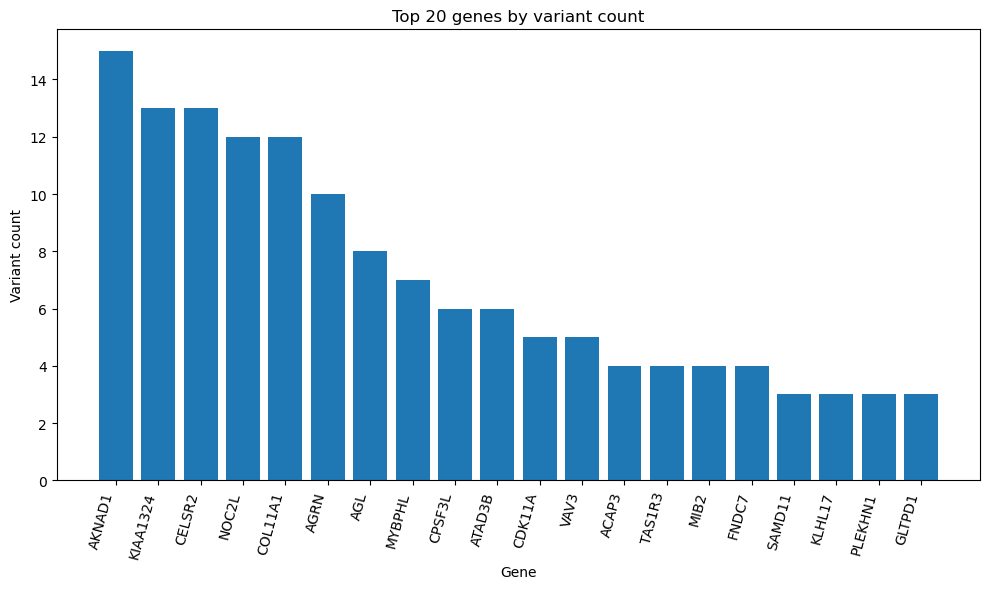

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# load genes_df from above (or rebuild)
try:
    genes_df = pd.read_csv(os.path.join(csv_dir, "genes_top.csv"))
except Exception:
    genes_df = pd.DataFrame(results.get('top_genes', []), columns=['gene','count'])

# choose top N
N = 20
plot_df = genes_df.head(N)
plt.figure(figsize=(10,6))
plt.bar(plot_df['gene'].astype(str), plot_df['count'])
plt.xticks(rotation=75, ha='right')
plt.title(f"Top {min(N,len(plot_df))} genes by variant count")
plt.ylabel("Variant count")
plt.xlabel("Gene")
plt.tight_layout()
plt.show()


# Per-chromosome variant counts (bar chart)

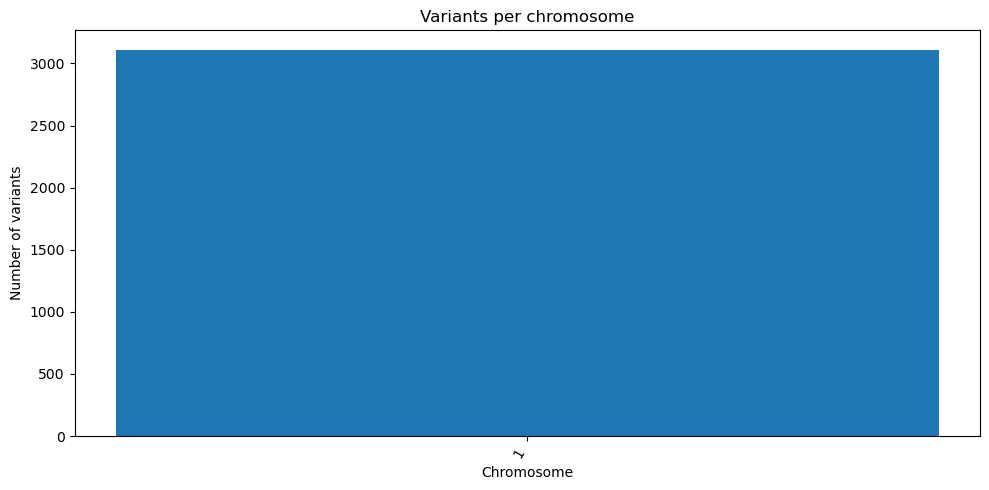

In [46]:
# per_chrom_df from CSV
per_chrom_df = pd.read_csv(os.path.join(csv_dir, "per_chromosome_counts.csv"))

# sort by chromosome sensibly (numeric where possible)
def chrom_key(x):
    try:
        return (0, int(x))
    except:
        return (1, x)
per_chrom_df['sort_key'] = per_chrom_df['chrom'].astype(str).map(lambda c: chrom_key(c))
per_chrom_df = per_chrom_df.sort_values('sort_key')
plt.figure(figsize=(10,5))
plt.bar(per_chrom_df['chrom'].astype(str), per_chrom_df['variant_count'])
plt.xticks(rotation=60, ha='right')
plt.title("Variants per chromosome")
plt.xlabel("Chromosome")
plt.ylabel("Number of variants")
plt.tight_layout()
plt.show()


# Top traits/clinical significance (bar chart)

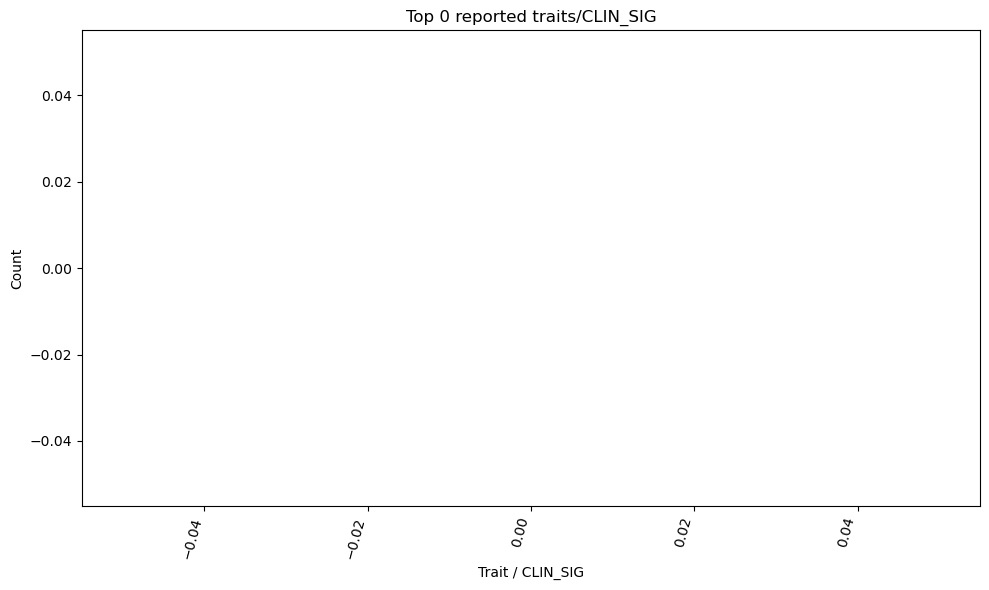

In [56]:
traits_df = pd.read_csv(os.path.join(csv_dir, "traits_top.csv"))
plot_n = 20
plt.figure(figsize=(10,6))
plt.bar(traits_df['trait'].astype(str).head(plot_n), traits_df['count'].head(plot_n))
plt.xticks(rotation=75, ha='right')
plt.title(f"Top {min(plot_n,len(traits_df))} reported traits/CLIN_SIG")
plt.ylabel("Count")
plt.xlabel("Trait / CLIN_SIG")
plt.tight_layout()
plt.show()


# Optional (Save patho variants as Excel (one sheet))

In [59]:
# requires openpyxl (pip install openpyxl) if you want Excel output
try:
    patho_df.to_excel(os.path.join(csv_dir, "pathogenic_variants.xlsx"), index=False)
    print("Wrote pathogenic_variants.xlsx")
except Exception as e:
    print("Skipping Excel export (openpyxl may be missing). Error:", e)


Wrote pathogenic_variants.xlsx


# Analysis of test2_data_annotated.vcf

In [62]:
# Config for test2
vcf_path = r"D:\clovertex_assignment\test2_data_annotated.vcf"

# Output directory and log paths
out_dir = os.path.splitext(vcf_path)[0] + "_analysis"
os.makedirs(out_dir, exist_ok=True)
json_log_path = os.path.join(out_dir, "vcf_analysis_log.json")
text_log_path = os.path.join(out_dir, "vcf_analysis_log.txt")


In [68]:
results = analyze_vep_vcf(vcf_path)
with open(json_log_path, 'w') as jf:
    json.dump(results, jf, indent=2)
write_text_report(results, text_log_path)
print("Analysis finished successfully for test2.")


Text log written to: D:\clovertex_assignment\test2_data_annotated_analysis\vcf_analysis_log.txt
Analysis finished successfully for test2.


In [72]:
import os

for root, dirs, files in os.walk(out_dir):
    level = root.replace(out_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")


test2_data_annotated_analysis/
    vcf_analysis_log.json
    vcf_analysis_log.txt


# Setting path for test2

In [83]:
# Point to test2 annotated VCF (Windows path)
vcf_path = r"D:\clovertex_assignment\test2_data_annotated.vcf"

# Output directory for logs & CSV
out_dir = os.path.splitext(vcf_path)[0] + "_analysis"
os.makedirs(out_dir, exist_ok=True)
json_log_path = os.path.join(out_dir, "vcf_analysis_log.json")
text_log_path = os.path.join(out_dir, "vcf_analysis_log.txt")


# Run analysis

In [86]:
results = analyze_vep_vcf(vcf_path)

# Save results
with open(json_log_path, 'w') as jf:
    json.dump(results, jf, indent=2)
write_text_report(results, text_log_path)
print("Analysis finished successfully for test2.")


Text log written to: D:\clovertex_assignment\test2_data_annotated_analysis\vcf_analysis_log.txt
Analysis finished successfully for test2.


# Export CSV outputs

In [89]:
csv_dir = os.path.join(out_dir, "csv_outputs")
os.makedirs(csv_dir, exist_ok=True)

# Genes
genes_df = pd.DataFrame(results.get('top_genes', []), columns=['gene', 'count'])
genes_df.to_csv(os.path.join(csv_dir, "genes_top.csv"), index=False)

# Traits
traits_df = pd.DataFrame(results.get('top_traits', []), columns=['trait', 'count'])
traits_df.to_csv(os.path.join(csv_dir, "traits_top.csv"), index=False)

# Pathogenic variants
patho_df = pd.DataFrame(results.get('pathogenic_variants', []))
patho_df.to_csv(os.path.join(csv_dir, "pathogenic_variants.csv"), index=False)

# Per-chromosome counts
per_chrom_df = pd.DataFrame(results.get('per_chrom_counts', {}).items(), columns=['chrom','variant_count'])
per_chrom_df.to_csv(os.path.join(csv_dir, "per_chromosome_counts.csv"), index=False)


# Plot graphs for test2

## a) Top Genes

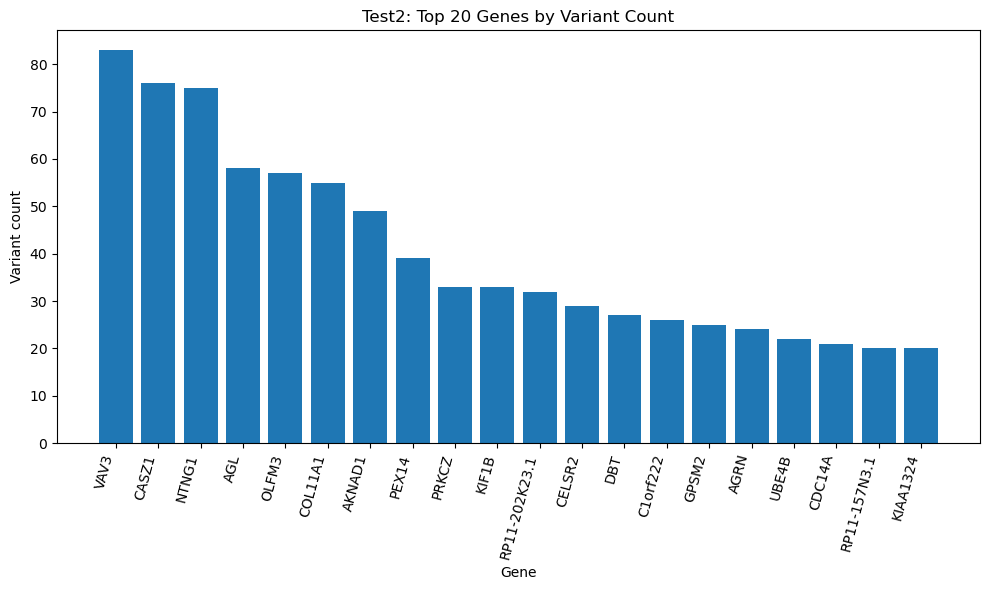

In [94]:
plt.figure(figsize=(10,6))
plt.bar(genes_df['gene'].astype(str).head(20), genes_df['count'].head(20))
plt.xticks(rotation=75, ha='right')
plt.title("Test2: Top 20 Genes by Variant Count")
plt.ylabel("Variant count")
plt.xlabel("Gene")
plt.tight_layout()
plt.show()


## b) Per-Chromosome Variant Counts

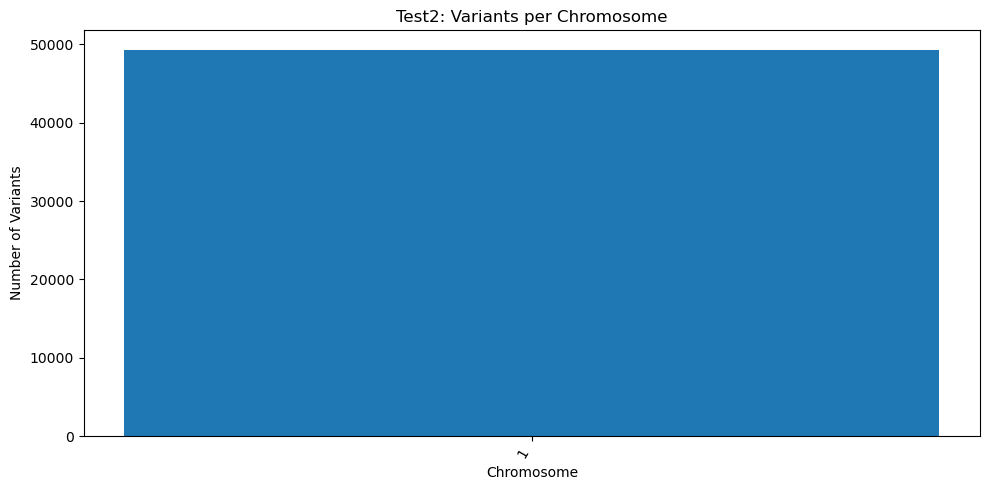

In [101]:
# Sort chromosomes numerically when possible
def chrom_key(x):
    try: return (0,int(x))
    except: return (1,x)

per_chrom_df['sort_key'] = per_chrom_df['chrom'].astype(str).map(lambda c: chrom_key(c))
per_chrom_df = per_chrom_df.sort_values('sort_key')

plt.figure(figsize=(10,5))
plt.bar(per_chrom_df['chrom'].astype(str), per_chrom_df['variant_count'])
plt.xticks(rotation=60, ha='right')
plt.title("Test2: Variants per Chromosome")
plt.xlabel("Chromosome")
plt.ylabel("Number of Variants")
plt.tight_layout()
plt.show()


## c) Top Traits

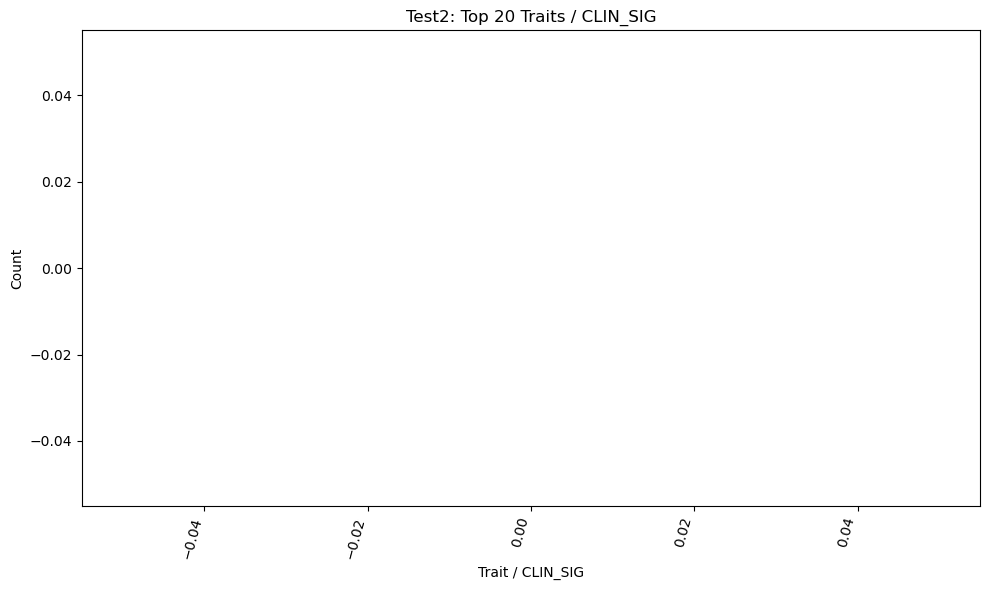

In [104]:
plt.figure(figsize=(10,6))
plt.bar(traits_df['trait'].astype(str).head(20), traits_df['count'].head(20))
plt.xticks(rotation=75, ha='right')
plt.title("Test2: Top 20 Traits / CLIN_SIG")
plt.ylabel("Count")
plt.xlabel("Trait / CLIN_SIG")
plt.tight_layout()
plt.show()
